# Q1 (bad_xml)

In [1]:
import gzip, sys, os, re
from pyspark import SparkContext
from datetime import datetime, timedelta

import xml.etree.ElementTree as ET
import numpy as np

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [ ]:
def localpath(path):
    return str(os.path.abspath(os.path.curdir)) + path

def startsWithRow(line):
    return len( re.compile(u'^<row ').findall(line.strip()) ) > 0

def applyParser(line):
    try:
        root = ET.fromstring(re.compile(u'(^<row(.*?)\/>)').findall(line.strip())[0][0].encode('utf-8').strip())
        
        return root
    except:
        return None

In [7]:
my_input_dir = r'\spark-stats-data\allPosts\part-0*'

lines_1 = sc.textFile(localpath(my_input_dir)).map(startsWithRow).filter(lambda x: x is True).count()
lines_2 = sc.textFile(localpath(my_input_dir)).map(applyParser).filter(lambda x: x is not None).count()
lines_3 = lines_1-lines_2

print("lines with posts:\t {0}".format(lines_1) )
print("readable lines:\t\t {0}".format(lines_2) )
print("unreadable posts:\t {0}".format(lines_3) )

lines with posts:	 109522
readable lines:		 108721
unreadable posts:	 801


# Q2 (upvote_percentage)

In [8]:
class Vote_El(object): #I get a pickle error
    def __init__(self, PostId, Up, Down, Fav):
        self.PostId = PostId
        self.Up = Up
        self.Down = Down
        self.Fav = Fav
    
def Parse_Vote(line):
    
    root = applyParser(line)
    
    if root is not None:
        
        try:
            PostId = int(root.get('PostId'))
            Up, Down, Fav = 0, 0, 0
        
            var = int(root.get('VoteTypeId'))
            if var == 2: Up += 1
            elif var == 3: Down += 1
            elif var == 5: Fav += 1
        
            #return Vote_El(PostId, Up, Down, Fav)
            return (PostId, Up, Down, Fav)
        
        except:
            return None
        
    else:
        return None

In [31]:
my_input_dir = r'spark-stats-data\allVotes\part-0*'

top_50 = sc.textFile(my_input_dir).map(Parse_Vote).filter(lambda x: x is not None)\
        .map(lambda x: (x[0], (x[1], x[2], x[3])) )\
        .reduceByKey(lambda x,y: (x[0]+y[0], x[1]+y[1], x[2]+y[2]) )\
        .map(lambda k_v: (k_v[1][2], (k_v[1][0], k_v[1][1])) )\
        .reduceByKey(lambda x,y: (x[0]+y[0], x[1]+y[1]) )\
        .map(lambda k_v: (  k_v[0], k_v[1][0]/float(k_v[1][0]+k_v[1][1])  )  )\
        .sortByKey(ascending=True).take(50)

In [ ]:
# python 3 does not like the auto tuple unpacking

# .map(lambda (key,val): (val[2], (val[0], val[1])) )
# has to be changed as follows
# .map(lambda k_v: (k_v[1][2], (k_v[1][0], k_v[1][1])) )

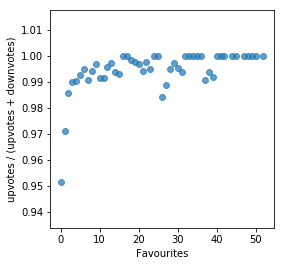

In [59]:
data = np.array([ [el[0], el[1]] for el in top_50 ])

plt.figure(figsize=(4, 4))
plt.scatter( data[:,0],  data[:,1], alpha=0.7)
plt.xlabel('Favourites')
plt.ylabel('upvotes / (upvotes + downvotes)')
plt.show()

# Q3  (answer_percentage)   

In [34]:
import numbers

def Get_Ustr_Info(line):
    
    root = applyParser(line)
    
    if root is not None:
        try:    
            UsrId = int(root.get('Id'))
            Reputation = int(root.get('Reputation'))
            return (UsrId, Reputation)
        
        except:
            return None
        
    else:
        return None
    
def Get_Posts_Info(line):
    
    root = applyParser(line)
    
    if root is not None:
        try:
            
            if 'OwnerUserId' in root.attrib:
                UsrId = int(root.attrib['OwnerUserId'])
            else:
                UsrId = -2
            
            quest, answ = 0, 0
            
            var = int(root.get('PostTypeId')) 
            if var == 1: quest += 1
            elif var == 2: answ += 1
            
            return (UsrId, (quest, answ))
        except:
            return None
    else:
        return None
    
def Filter(el):
    try:
        key, val = el
        if isinstance(key, numbers.Number) and isinstance(val[1], numbers.Number) and isinstance(val[0][0], numbers.Number) and isinstance(val[0][1], numbers.Number):
            return True
        else:
            False
    except:
        return False

In [42]:
my_input_Posts = r'spark-stats-data\allPosts\part-0*'
my_input_Users = r'spark-stats-data\allUsers\part-0*'

posts = sc.textFile(my_input_Posts).map(Get_Posts_Info).filter(lambda x: x is not None)
users = sc.textFile(my_input_Users).map(Get_Ustr_Info).filter(lambda x: x is not None)

In [ ]:
table = posts.join(users).filter(Filter)\
        .map(lambda k_v: (k_v[0], (k_v[1][1], k_v[1][0][0], k_v[1][0][1])) )\
        .reduceByKey(lambda x,y: (x[0], x[1]+y[1], x[2]+y[2]) )\
        .filter(lambda k_v: k_v[1][1]+k_v[1][2]!=0 )\
        .map(lambda k_v: (k_v[1][0], k_v[1][2]/float(k_v[1][1]+k_v[1][2])) )\
        .sortByKey(ascending=False)\
        .take(99)

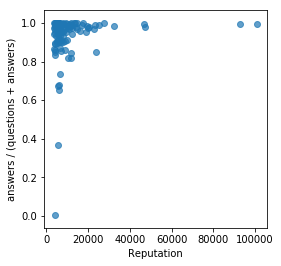

In [57]:
data = np.array([ [el[0], el[1]] for el in table ])

plt.figure(figsize=(4, 4))
plt.scatter( data[:,0],  data[:,1], alpha=0.7)
plt.xlabel('Reputation')
plt.ylabel('answers / (questions + answers)')
plt.show()

Average answer percentage

In [63]:
avg_ = posts.map(lambda k_v: (1, (k_v[1][0], k_v[1][1])) )\
        .reduceByKey(lambda x,y: (x[0]+y[0], x[1]+y[1]) )\
        .map(lambda k_v: (k_v[1][0], k_v[1][1], k_v[1][1]/float(k_v[1][0]+k_v[1][1])) )\
        .collect()
        
print('tot. Q = {0},\t\t tot. A = {1}, \t avg answer percentage = {2}'.format(avg_[0][0], avg_[0][1], avg_[0][2])  )

tot. Q = 52046,		 tot. A = 55298, 	 avg answer percentage = 0.5151475629751081


# Q4 (post_counts)

In [80]:
def parse_Posts_trf_3(line):    
    
    root = applyParser(line)
    
    if root is not None:
        try:
        
            if 'OwnerUserId' in root.attrib:
                OwnerUserId = int(root.attrib['OwnerUserId'])
            else:
                OwnerUserId = -2
                
            return (OwnerUserId, 1)
        
        except:
            return None
        
    else:
        return None
    

    
def parse_User_Record_trf_1(line):
    
    root = applyParser(line)
    
    if root is not None:
        try:
            Id, Reputation = int(root.attrib['Id']), int(root.attrib['Reputation'])
            return (Id, Reputation)
            
        except:
            return None
            
    else:
        return None

In [88]:
my_input_dir = r'spark-stats-data\allPosts\part-0*'

Own_Id_vs_QA = sc.textFile(my_input_dir)\
    .map(parse_Posts_trf_3)\
    .filter(lambda x: x is not None)\
    .reduceByKey(lambda va, vb: va+vb)
    
my_input_dir = r'spark-stats-data\allUsers\part-0*'

Usr_Id_vs_Rep = sc.textFile(my_input_dir)\
    .map(parse_User_Record_trf_1)\
    .filter(lambda x: x is not None)

# qa____RepSum_Counts = (qa, (rep_sum, counts))
# UsrId___rep_qa = (UsrId, (rep, qa))
# QA____AvgRep = (QA, AvgRep)

Usr_Id_vs_Rep_vs_QA = Usr_Id_vs_Rep.join(Own_Id_vs_QA)\
    .map(lambda UsrId___rep_qa: (UsrId___rep_qa[1][1], (UsrId___rep_qa[1][0],1)) )\
    .reduceByKey(lambda va, vb: (va[0]+vb[0], va[1]+vb[1]))\
    .map(lambda qa____RepSum_Counts:  (qa____RepSum_Counts[0], float(qa____RepSum_Counts[1][0]/qa____RepSum_Counts[1][1])) )\
    .sortBy(lambda QA____AvgRep: QA____AvgRep[0], ascending=False)\
    .collect()

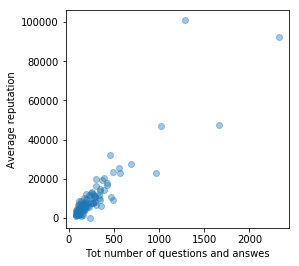

In [91]:
data = np.array([ [el[0], el[1]] for el in Usr_Id_vs_Rep_vs_QA[:100] ])

plt.figure(figsize=(4, 4))
plt.scatter( data[:,0],  data[:,1], alpha=0.4)
plt.xlabel('Tot number of questions and answes')
plt.ylabel('Average reputation')
plt.show()

## Q5 (quick_answers)
        Id
        PostTypeId
          - 1: Question
          - 2: Answer
       - ParentID (only present if PostTypeId is 2)
       - AcceptedAnswerId (only present if PostTypeId is 1)
       - CreationDate
       
questoins: (Q_id, acc_answer_id, creation_date)  
answer:    (A_id, ParentID, creation_date  )

In [93]:
def parse_Posts_trf_2(line): 
    
    root = applyParser(line)
    
    if root is not None:
        
        try:    
            if 'Id' in root.attrib:
                Id = int(root.attrib['Id'])
            else:
                Id = -2
            
            #or just return None if CreationDate is not given
            if 'CreationDate' in root.attrib:
                CreationDate = datetime.strptime(root.attrib['CreationDate'], '%Y-%m-%dT%H:%M:%S.%f').replace(microsecond=0)
            else:
                CreationDate = datetime.datetime(1970, 1, 1, 0, 0, 0)
            
            PostTypeId = int(root.attrib['PostTypeId'])
            if PostTypeId == 2:
                if 'ParentID' in root.attrib:
                    ParentID         = int(root.attrib['ParentID'])
                else:
                    ParentID         = -2
                return (Id, ParentID, CreationDate, 'A')
                
            if PostTypeId == 1:
                if 'AcceptedAnswerId' in root.attrib:
                    AcceptedAnswerId = int(root.attrib['AcceptedAnswerId'])
                else:
                    AcceptedAnswerId = -2
                return (Id, AcceptedAnswerId, CreationDate, 'Q')

            return None        
        
        except:
            return None
    
    else:
        return None

In [105]:
my_input_dir = r'spark-stats-data\allPosts\part-0*'

q_with_acc_answ = sc.textFile(my_input_dir)\
    .map(parse_Posts_trf_2)\
    .filter(lambda x: x is not None)\
    .filter(lambda x: x[0]!=-2 and x[1]!=-2 and x[2]!=datetime(1970, 1, 1, 0, 0, 0) and x[3]=='Q')

answ = sc.textFile(my_input_dir)\
    .map(parse_Posts_trf_2)\
    .filter(lambda x: x is not None)\
    .filter(lambda x: x[0]!=-2 and              x[2]!=datetime(1970, 1, 1, 0, 0, 0) and x[3]=='A')
    
acc_answ_in_my_set = q_with_acc_answ.map(lambda x: (x[1], x[2]))\
    .join( answ.map(lambda x: (x[0],x[2]) ) )
    
quick_acc_answ_in_my_set = acc_answ_in_my_set.filter(lambda x: x[1][1]-x[1][0]<timedelta(0, 10800) )

tot_acc_answ_by_q_hour = acc_answ_in_my_set.map(lambda x: (x[1][0].hour ,1) )\
    .reduceByKey(lambda x, y: x+y)\
    .sortByKey().collect()
    
tot_quick_acc_answ_by_hour = quick_acc_answ_in_my_set.map(lambda x: (x[1][0].hour ,1) )\
    .reduceByKey(lambda x, y: x+y)\
    .sortByKey().collect()

In [110]:
q5_res = []
for el1, el2 in zip(tot_acc_answ_by_q_hour, tot_quick_acc_answ_by_hour):
    q5_res.append(float(el2[1])/el1[1])

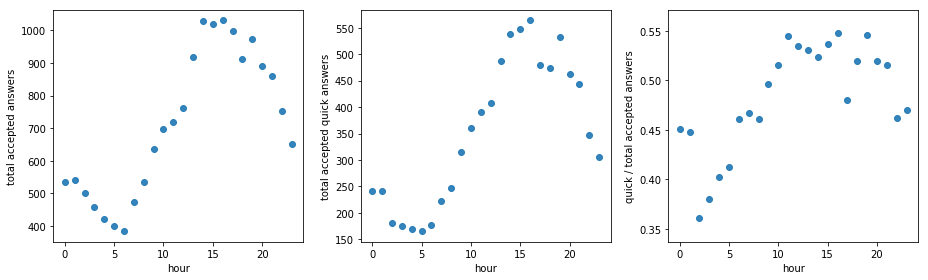

In [116]:
data       = np.array([ [el[0], el[1]] for el in tot_acc_answ_by_q_hour     ])
data_quick = np.array([ [el[0], el[1]] for el in tot_quick_acc_answ_by_hour ])


plt.figure(figsize=(13, 4))

plt.subplot(1,3,1)
plt.scatter( data[:,0],  data[:,1], alpha=0.9)
plt.xlabel('hour')
plt.ylabel('total accepted answers')
plt.tight_layout()

plt.subplot(1,3,2)
plt.scatter( data_quick[:,0],  data_quick[:,1], alpha=0.9)
plt.xlabel('hour')
plt.ylabel('total accepted quick answers')
plt.tight_layout()

plt.subplot(1,3,3)
plt.scatter( np.arange(0,24,1), q5_res, alpha=0.9)
plt.xlabel('hour')
plt.ylabel('quick / total accepted answers')
plt.tight_layout()

plt.show()

# Q6 (quick_answers_full)   
TODO...

In [ ]:
my_input_dir = r'spark-stack-data\allPosts\part-0*'


q_with_acc_answ = sc.textFile(my_input_dir)\
    .map(parse_Posts_trf_2)\
    .filter(lambda x: x is not None)\
    .filter(lambda x: x[0]!=-2 and x[1]!=-2 and x[2]!=datetime(1970, 1, 1, 0, 0, 0) and x[3]=='Q')

answ = sc.textFile(my_input_dir)\
    .map(parse_Posts_trf_2)\
    .filter(lambda x: x is not None)\
    .filter(lambda x: x[0]!=-2 and              x[2]!=datetime(1970, 1, 1, 0, 0, 0) and x[3]=='A')
    
acc_answ_in_my_set = q_with_acc_answ.map(lambda x: (x[1], x[2]))\
    .join( answ.map(lambda x: (x[0],x[2]) ) )
    
quick_acc_answ_in_my_set = acc_answ_in_my_set.filter(lambda x: x[1][1]-x[1][0]<timedelta(0, 10800) )

tot_acc_answ_by_q_hour = acc_answ_in_my_set.map(lambda x: (x[1][0].hour ,1) )\
    .reduceByKey(lambda x, y: x+y)\
    .sortByKey().collect()
    
tot_quick_acc_answ_by_hour = quick_acc_answ_in_my_set.map(lambda x: (x[1][0].hour ,1) )\
    .reduceByKey(lambda x, y: x+y)\
    .sortByKey().collect()

In [ ]:
q6_res = []
for el1, el2 in zip(tot_acc_answ_by_q_hour, tot_quick_acc_answ_by_hour):
    q6_res.append(float(el2[1])/el1[1])

In [ ]:
data       = np.array([ [el[0], el[1]] for el in tot_acc_answ_by_q_hour     ])
data_quick = np.array([ [el[0], el[1]] for el in tot_quick_acc_answ_by_hour ])


plt.figure(figsize=(13, 4))

plt.subplot(1,3,1)
plt.scatter( data[:,0],  data[:,1], alpha=0.9)
plt.xlabel('hour')
plt.ylabel('total accepted answers')
plt.tight_layout()

plt.subplot(1,3,2)
plt.scatter( data_quick[:,0],  data_quick[:,1], alpha=0.9)
plt.xlabel('hour')
plt.ylabel('total accepted quick answers')
plt.tight_layout()

plt.subplot(1,3,3)
plt.scatter( np.arange(0,24,1), q5_res, alpha=0.9)
plt.xlabel('hour')
plt.ylabel('quick / total accepted answers')
plt.tight_layout()

plt.show()

# Q7 (identify_veterans)
posts 100-150 days after account creation date -> (active vs inactive users)  
get first question of veterans and users  
for both groups: average the score, views, number of answers and number of favorites of the users' first question  

In [118]:
def parse_User_Record_trf_2(line):
    
    root = applyParser(line)
    
    if root is not None:
        try:
            
            if 'Id' in root.attrib: 
                Id = int(root.attrib['Id'])
            else: 
                Id = -2
    
            if 'CreationDate' in root.attrib: 
                CreationDate = datetime.strptime(root.attrib['CreationDate'], '%Y-%m-%dT%H:%M:%S.%f').replace(microsecond=0)
            else:
                CreationDate = datetime.datetime(1970, 1, 1, 0, 0, 0)
        
            return (Id, CreationDate)            
            
        except:
            return None
        
    else:
        return None

    
def parse_Posts_trf_4(line):
    
    root = applyParser(line)
    
    if root is not None:
        try:
            if 'OwnerUserId' in root.attrib: 
                OwnerUserId = int(root.attrib['OwnerUserId'])
            else: 
                OwnerUserId = -2
            
            if 'PostTypeId' in root.attrib: 
                PostTypeId = int(root.attrib['PostTypeId'])
            else: 
                PostTypeId = -2
            
            if 'CreationDate' in root.attrib: 
                CreationDate = datetime.strptime(root.attrib['CreationDate'], '%Y-%m-%dT%H:%M:%S.%f').replace(microsecond=0)
            else: 
                CreationDate = datetime.datetime(1970, 1, 1, 0, 0, 0)
            
            if 'Score' in root.attrib: 
                Score = int(root.attrib['Score'])
            else: 
                Score = 0 #-999999
            
            if 'ViewCount' in root.attrib: 
                ViewCount = int(root.attrib['ViewCount'])
            else: 
                ViewCount = 0 #-2
            
            if 'AnswerCount' in root.attrib: 
                AnswerCount = int(root.attrib['AnswerCount'])
            else: 
                AnswerCount = 0 #-2
            
            if 'FavoriteCount' in root.attrib: 
                FavoriteCount = int(root.attrib['FavoriteCount'])
            else: 
                FavoriteCount = 0 #-2
            
            return (OwnerUserId, PostTypeId, CreationDate, Score, ViewCount, AnswerCount, FavoriteCount)            
            
        except:
            return None
    else:
        return None

In [ ]:
my_input_dir = r'spark-stats-data\allUsers\part-0*'

Usr_Id_vs_Cr_date = sc.textFile(my_input_dir)\
    .map(parse_User_Record_trf_2)\
    .filter(lambda x: x is not None and x[1]!=datetime(1970, 1, 1, 0, 0, 0))

my_input_dir = r'spark-stats-data\allPosts\part-0*'

all_posts = sc.textFile(my_input_dir)\
    .map(parse_Posts_trf_4)\
    .filter(lambda x: x is not None and x[2]!=datetime(1970, 1, 1, 0, 0, 0))

first_q_by_usr = sc.textFile(my_input_dir)\
    .map(parse_Posts_trf_4)\
    .filter(lambda x: x is not None and x[0]!=-2 and x[1]==1 and x[2]!=datetime(1970, 1, 1, 0, 0, 0) and x[3]!=-999999 and x[4]!=-2 and x[5]!=-2 and x[6]!=-2 )\
    .map(lambda x: (x[0], (x[1],x[2],x[3],x[4],x[5],x[6]) ))\
    .reduceByKey(lambda x, y: x if x[1]<y[1] else y )

act_usr = Usr_Id_vs_Cr_date.join(  all_posts.map(lambda x: (x[0], x[2]))  )\
    .map(lambda x: (x[0], 1) if timedelta(100, 0)<x[1][1]-x[1][0]<timedelta(150, 0) else (x[0], 0) )\
    .reduceByKey(lambda x, y: x+y)\
    .filter(lambda x: x[1]>0)\
    .map(lambda x: (x[0],1) )

inact_usr = Usr_Id_vs_Cr_date.join(  all_posts.map(lambda x: (x[0], x[2]))  )\
    .map(lambda x: (x[0], 1) if timedelta(100, 0)<x[1][1]-x[1][0]<timedelta(150, 0) else (x[0], 0) )\
    .reduceByKey(lambda x, y: x+y)\
    .filter(lambda x: x[1]==0)\
    .map(lambda x: (x[0],1) )

act_usr_first_q_stats = act_usr.join(first_q_by_usr)\
    .map(lambda x: (x[1][1][2],x[1][1][3],x[1][1][4],x[1][1][5],1))\
    .reduce(lambda x, y: (x[0]+y[0], x[1]+y[1], x[2]+y[2], x[3]+y[3], x[4]+y[4]) )

inact_usr_first_q_stats = inact_usr.join(first_q_by_usr)\
    .map(lambda x: (x[1][1][2],x[1][1][3],x[1][1][4],x[1][1][5],1))\
    .reduce(lambda x, y: (x[0]+y[0], x[1]+y[1], x[2]+y[2], x[3]+y[3], x[4]+y[4]) )

In [132]:
au =  np.array([el for el in act_usr_first_q_stats])
iu =  np.array([el for el in inact_usr_first_q_stats])
au = au/float(au[-1])
iu = iu/float(iu[-1])

In [137]:
print('active user: \t Score = {0:.2f}\t ViewCount = {1:.2f}\t AnswerCount = {2:.2f}\t FavoriteCount = {3:.2f}'\
      .format(au[0],au[1],au[2],au[3]) )
print('inactive user: \t Score = {0:.2f}\t ViewCount = {1:.2f}\t AnswerCount = {2:.2f}\t FavoriteCount = {3:.2f}'\
      .format(iu[0],iu[1],iu[2],iu[3]) )

active user: 	 Score = 3.54	 ViewCount = 926.40	 AnswerCount = 1.30	 FavoriteCount = 1.30
inactive user: 	 Score = 2.10	 ViewCount = 553.39	 AnswerCount = 0.97	 FavoriteCount = 0.58


# Q9 (word2vec)   
TODO...   
using the tags of each StackExchange post as documents  
Spark ML's implementation of Word2Vec (this will require using DataFrames)  
list of the top 25 closest synonyms to "ggplot2" and their similarity score in tuple format ("string", number)  
dimensionality of the vector space should be 100. The random seed should be 42L.

In [ ]:
# needed to convert RDDs into DataFrames
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)

from pyspark.ml.feature import Word2Vec

In [ ]:
def parse_Posts_trf_5(line):    
    
    root = applyParser(line)
    
    if root is not None:
        try:
            Tags = re.compile('\w+').findall( root.attrib['Tags'] )
            return (Tags)
        except:
            return None
    else:
        return None